In [1]:
import numpy as np

In [2]:
rng = np.random.default_rng()

In [3]:
n = 1_000_000

In [4]:
cards = np.tile(np.arange(52, dtype=np.int16), (n, 1))

In [5]:
rng.permuted(cards, axis=1, out=cards);

In [6]:
imp_cards = cards[:, :49]

Shape: n, player, card

In [7]:
shaped_cards = imp_cards.reshape(n, 7, 7)

In [8]:
suit = shaped_cards//13
num = shaped_cards%13

In [9]:
shift_num = np.left_shift(1, num)

In [10]:
suit_bit_cards = np.empty((n, 7, 4), dtype=np.int16)

In [11]:
for i in range(4):
    np.bitwise_or.reduce(shift_num * (suit == i), axis=2, out=suit_bit_cards[..., i])

In [12]:
suit_counts = np.empty((n, 7, 4), dtype=np.int16)

In [13]:
for i in range(4):
    np.sum(suit == i, axis=2, out=suit_counts[..., i])

In [14]:
suit_max_counts = suit_counts.max(axis=-1)
max_suit = suit_counts.argmax(axis=-1)

In [15]:
max_suit_bit_cards = np.take_along_axis(suit_bit_cards, np.expand_dims(max_suit, -1), axis=2).squeeze()

In [16]:
house_too_small = ~((suit_max_counts[:, 0]>=3)&(max_suit_bit_cards[:, 0]>=(1<<8)))

In [17]:
results = np.sign(max_suit_bit_cards[:, 1:]-max_suit_bit_cards[:, 0:1])

In [18]:
results[suit_max_counts[:, 1:]>suit_max_counts[:, 0:1]] = 1
results[suit_max_counts[:, 1:]<suit_max_counts[:, 0:1]] = -1

In [19]:
max_bet = np.zeros_like(suit_max_counts)

In [20]:
max_bet[suit_max_counts<=4] = 2
max_bet[suit_max_counts==5] = 3
max_bet[suit_max_counts>=6] = 4

In [21]:
import torch
from torch import nn
import torch.nn.functional as F

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
class SimplePredictor(nn.Module):
    def __init__(self, emb_dim=5, hid_dim=10):
        super().__init__()
        self.emb = nn.Embedding(52, emb_dim)
        self.l1 = nn.Linear(emb_dim, hid_dim)
        self.l2 = nn.Linear(hid_dim, 1)
    
    def forward(self, x):
        x = self.emb(x)
        x = self.l1(x)
        x = x.sum(dim=-2)
        x = F.relu(x)
        x = self.l2(x)
        x = torch.tanh(x)
        return x

In [24]:
train_size = round(n*0.7)
val_size = round(n*0.15)
train_size, val_size, n-train_size-val_size

(700000, 150000, 150000)

In [25]:
X = torch.tensor(shaped_cards[:train_size, 1:, :], dtype=torch.int32, device=device)
t_max = torch.tensor(max_bet[:train_size, 1:], dtype=torch.int32, device=device)
Y = torch.tensor(results[:train_size, :], dtype=torch.float32, device=device)
t_nai = Y * t_max

In [26]:
val_X = torch.tensor(shaped_cards[train_size:train_size+val_size, 1:, :], dtype=torch.int32, device=device)
val_max = torch.tensor(max_bet[train_size:train_size+val_size, 1:], dtype=torch.int32, device=device)
val_Y = torch.tensor(results[train_size:train_size+val_size, :], dtype=torch.float32, device=device)
val_nai = val_Y * val_max

In [209]:
simp_pred = SimplePredictor().to(device=device)

In [210]:
lr=0.1

In [211]:
def asym_loss(mul=2):
    def loss(pred, tgt):
        return (((pred < tgt) * (mul-1) + 1) * (pred-tgt).abs()).mean()
    return loss

In [224]:
mse=asym_loss(mul=1.00)

In [225]:
optim=torch.optim.Adam(simp_pred.parameters(), lr=lr)

In [226]:
losses = []
val_losses = []
for i in range(1001):
    optim.zero_grad()
    
    loss = mse(simp_pred(X).squeeze(), Y)
    losses.append(loss.item())
    
    loss.backward()
    optim.step()
    
    if i%100 == 0:
        with torch.no_grad():
            loss = mse(simp_pred(val_X).squeeze(), val_Y)
            val_losses.append(loss.item())
            print(f"Epoch {i}: {loss.item()}")

Epoch 0: 0.7842665314674377
Epoch 100: 0.68296879529953
Epoch 200: 0.6800105571746826
Epoch 300: 0.6796910166740417
Epoch 400: 0.6797274947166443
Epoch 500: 0.6795465350151062
Epoch 600: 0.6796022653579712
Epoch 700: 0.6905087828636169
Epoch 800: 0.6280180811882019
Epoch 900: 0.6275476813316345
Epoch 1000: 0.6274371147155762


In [227]:
train_pred = simp_pred(X).squeeze().cpu().detach().numpy()
np_t_nai = t_nai.cpu().detach().numpy()

res = []
for i in np.arange(1, -1, -0.1):
    ai_outcome = np.copy(np_t_nai)
    ai_outcome[train_pred<i] = -1
    res.append(ai_outcome.mean())

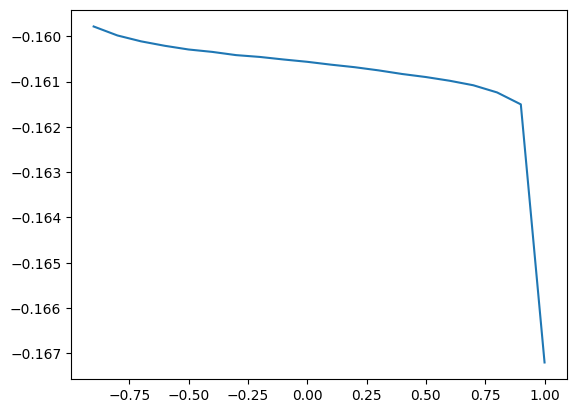

In [228]:
plt.plot(np.arange(1, -1, -0.1), res)

In [39]:
import matplotlib.pyplot as plt

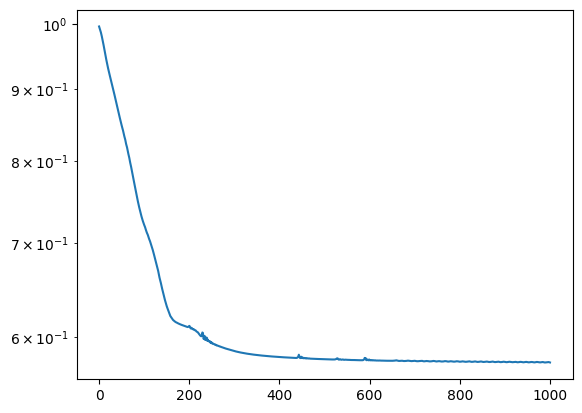

In [41]:
plt.plot(losses)
plt.yscale('log')

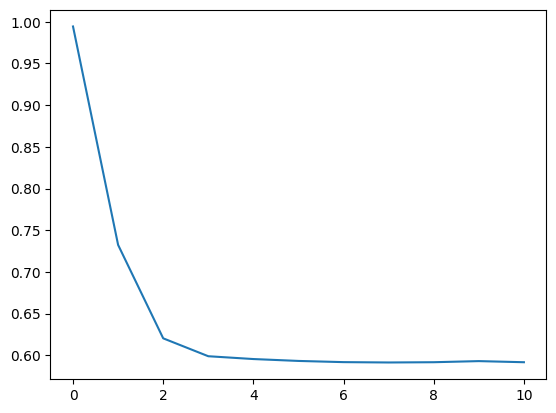

In [42]:
plt.plot(val_losses)

In [239]:
with torch.no_grad():
    val_pred = simp_pred(val_X).round().squeeze().cpu().detach().numpy().astype(int)
    val_float_pred = simp_pred(val_X).squeeze().cpu().detach().numpy()

In [43]:
with torch.no_grad():
    val_pred = mixed(val_X, encoder(val_X).round()).round().squeeze().cpu().detach().numpy().astype(int)
    val_float_pred = mixed(val_X, encoder(val_X).round()).squeeze().cpu().detach().numpy()

In [44]:
val_tgt=results[train_size:train_size+val_size, :]

In [45]:
def conf_matrix(val_pred, val_tgt):
    res = []
    for i in range(-1, 2):
        a = []
        for j in range(-1, 2):
            a.append(((val_pred==i)&(val_tgt==j)).sum())
        res.append(a)
    return np.array(res)

In [46]:
conf = conf_matrix(val_pred, val_tgt)

In [47]:
frac_conf = conf/conf.sum()

In [48]:
frac_conf

array([[3.91148889e-01, 7.98888889e-04, 1.85976667e-01],
       [8.60777778e-03, 3.33333333e-05, 1.05411111e-02],
       [9.94177778e-02, 3.70000000e-04, 3.03105556e-01]])

/tmp/ipykernel_28081/2595253012.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(("", "Loss", "Tie", "Win"))
/tmp/ipykernel_28081/2595253012.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(("", "Loss", "Tie", "Win"))


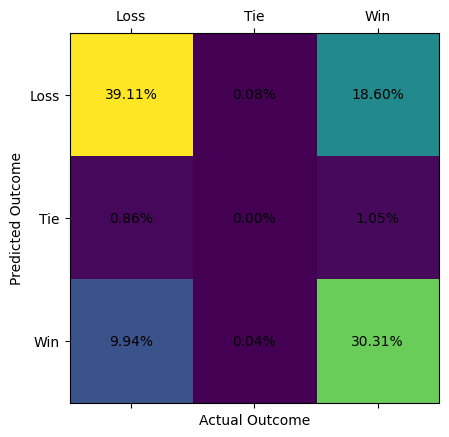

In [49]:
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(frac_conf)

for (i, j), z in np.ndenumerate(frac_conf):
    ax.text(j, i, '{:0.2f}%'.format(z*100), ha='center', va='center')
ax.set_xticklabels(("", "Loss", "Tie", "Win"))
ax.set_yticklabels(("", "Loss", "Tie", "Win"))
ax.set_xlabel("Actual Outcome")
ax.set_ylabel("Predicted Outcome")
plt.show()

In [55]:
val_suit = suit_max_counts[train_size:train_size+val_size, 1:]

In [65]:
val_small = house_too_small[train_size:train_size+val_size]

In [56]:
max_bet = np.zeros_like(val_suit)

In [57]:
max_bet[val_suit<=4] = 2
max_bet[val_suit==5] = 3
max_bet[val_suit>=6] = 4

In [58]:
naive_outcome = val_tgt * max_bet

In [68]:
filtered_outcome = np.copy(naive_outcome)
filtered_outcome[val_small, :] = 1

In [250]:
ai_outcome = np.copy(naive_outcome)
ai_outcome[val_pred<0] = -1

In [251]:
(np.mean(val_pred>0))

0.48897

In [66]:
val_small.shape

(150000,)

In [71]:
filtered_outcome.mean(axis=0)

array([-0.06090667, -0.05726   , -0.05836   , -0.05428667, -0.05338667,
       -0.05066667])

In [95]:
val_pred

array([[-1, -1, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1, -1],
       ...,
       [ 1,  1, -1, -1, -1, -1],
       [-1,  1,  1, -1, -1, -1],
       [ 1,  1, -1,  1,  1,  1]])

In [238]:
simp_pred.load_state_dict(torch.load('simp_pred.pt'))

<All keys matched successfully>

In [27]:
from itertools import *

In [28]:
class SimpleEncoder(nn.Module):
    def __init__(self, emb_dim=5, hid_dim=10, out_dim=5):
        super().__init__()
        self.emb = nn.Embedding(52, emb_dim)
        self.l1 = nn.Linear(emb_dim, hid_dim)
        self.l2 = nn.Linear(hid_dim, out_dim)
    
    def forward(self, x):
        x = self.emb(x)
        x = self.l1(x)
        x = x.sum(dim=-2)
        x = F.relu(x)
        x = self.l2(x)
        x = torch.sigmoid(8*x)
        return x

In [29]:
class MixedPredictor(nn.Module):
    def __init__(self, emb_dim=5, hid_dim=10, hint_dim=5):
        super().__init__()
        self.emb = nn.Embedding(52, emb_dim)
        self.m1 = nn.Linear(6*hint_dim, emb_dim)
        self.l1 = nn.Linear(emb_dim, hid_dim)
        self.l2 = nn.Linear(hid_dim+hint_dim, 1)
    
    def forward(self, x, hint):
        x = self.emb(x)
        h2 = hint.reshape(hint.shape[0], -1)
        h2 = self.m1(h2)
        x = self.l1(x)
        x = x.sum(dim=-2)
        x = F.relu(x)
        h2 = torch.tile(h2, (6, 1, 1)).transpose(0, 1)
        x = torch.concat((x, h2), dim=2)
        x = self.l2(x)
        x = torch.tanh(x)
        return x

In [30]:
encoder = SimpleEncoder().to(device=device)

In [31]:
mixed = MixedPredictor().to(device=device)

In [32]:
hint = encoder(X)

In [33]:
lr=0.01

In [34]:
def asym_loss(mul=2):
    def loss(pred, tgt):
        return (((pred < tgt) * (mul-1) + 1) * (pred-tgt).abs()).mean()
    return loss

In [35]:
mse=asym_loss(mul=1.01)

In [36]:
optim=torch.optim.Adam(chain(encoder.parameters(), mixed.parameters()), lr=lr)

In [53]:
losses = []
val_losses = []
for i in range(1001):
    optim.zero_grad()
    
    hint = encoder(X)
    
    loss = mse(mixed(X, hint).squeeze(), Y)
    losses.append(loss.item())
    
    loss.backward()
    optim.step()
    
    if i%100 == 0:
        with torch.no_grad():
            hint = encoder(val_X).round()
            loss = mse(mixed(val_X, hint).squeeze(), val_Y)
            val_losses.append(loss.item())
            print(f"Epoch {i}: {loss.item()}")

Epoch 0: 0.5951974987983704
Epoch 100: 0.5958511233329773
Epoch 200: 0.5942739248275757
Epoch 300: 0.595772922039032
Epoch 400: 0.5955526828765869
Epoch 500: 0.5947486758232117
Epoch 600: 0.5939888954162598
Epoch 700: 0.5938815474510193
Epoch 800: 0.5920277833938599
Epoch 900: 0.5919722318649292
Epoch 1000: 0.5915623903274536
